<a href="https://colab.research.google.com/github/yasego/HandsOnML/blob/main/hands_on_ml_ch16_ex8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**8.**
연습문제: 호크라이터와 슈미트후버는 LSTM에 관한 논문에서 임베딩된 레버 문법을 사용했습니다. 이는 ‘BPBTSXXVPSEPE’와 같은 문자열을 만드는 인공 문법입니다. 이 주제에 대한 제니 오어의 훌륭한 소개(https://homl.info/108)%EB%A5%BC 확인해보세요. 특정 임베딩된 레버 문법 하나를 선택하고(제니 오어의 페이지에 있는 것과 같은), 그다음에 문자열이 이 문법을 따르는지 아닌지 구별하는 RNN을 훈련해보세요. 먼저 문법에 맞는 문자열 50%와 그렇지 않은 문자열 50%를 담은 훈련 배치를 생성하는 함수를 만들어야 합니다.


---


임베딩된 레버 문법(Embedded Reber Grammar)은 신경망 모델의 학습에 이용되는 인공 언어입니다. 이 문법은 이전에 Carlisle에 의해 제안된 Reber Grammar의 변형으로, Reber Grammar에서 사용되는 규칙들을 임베딩하여 더 복잡한 문법을 만들어냅니다.

Embedded Reber Grammar은 일련의 문자열을 생성하는 규칙으로 이루어져 있습니다. 이 규칙은 여러 개의 층(layer)으로 구성되어 있으며, 각 층은 다양한 문자열과 전이(transition) 규칙으로 이루어져 있습니다. 이전 층에서 생성된 문자열이 다음 층에서 입력으로 사용되어 새로운 문자열을 생성하는 방식으로 작동합니다.

이러한 Embedded Reber Grammar은 신경망 모델을 학습시킬 때 사용되며, 모델이 복잡한 문법을 이해하고 생성하는 능력을 향상시키는 데에 도움이 됩니다. 이를 통해 자연어 처리 분야에서 문자열 생성 문제를 해결하는 데에 이용되기도 합니다.






---

Reber 문법은 1976년에 Psychologist Karl Reber가 제안한 인공 언어 모델로, 의미없는 문자열을 생성하고 분석하는 데 사용됩니다.

*  BT<reber string>TE : legal 
*  BP<reber string>PE : legal 
*  BP<reber string>TE : illegal 


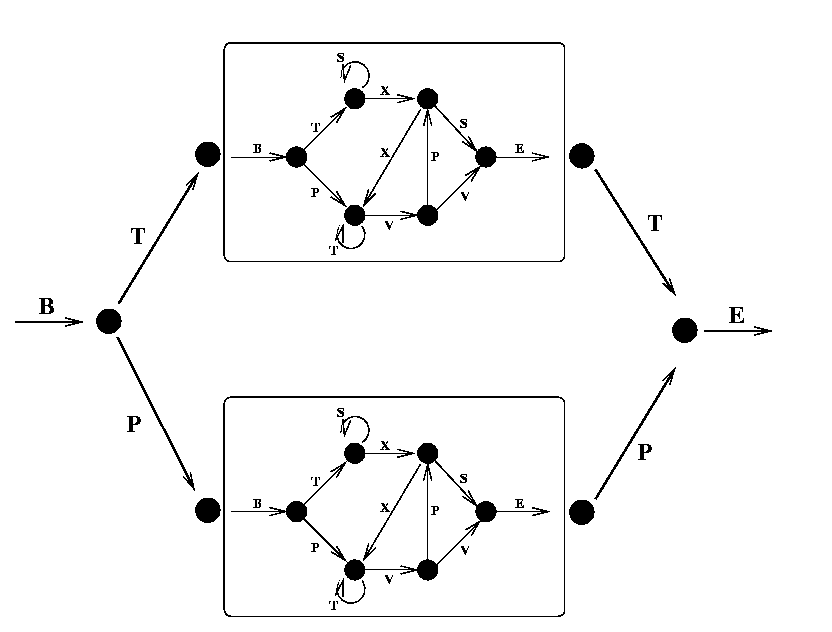


In [2]:
#@title
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩에서만 동작합니다.
    %tensorflow_version 2.x
    %pip install -q -U tensorflow-addons
    %pip install -q -U transformers
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 17.3 MB/s eta 0:00:00
감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.
런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.


In [3]:

#먼저 문법에 맞는 문자열을 생성하는 함수가 필요합니다. 
#이 문법은 각 상태에서 가능한 전이 상태의 리스트입니다. 
#하나의 전이는 출력할 문자열(또는 생성할 문법)과 다음 상태를 지정합니다.


default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

In [4]:
# 기본 레버 문법에 맞는 문자열을 몇 개 만들어 보겠습니다:

for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

In [6]:
# 이제 임베딩된 레버 문법에 맞는 문자열을 몇 개 만들어 보겠습니다:

for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

BTBPTTTVPXTVPXTTVPSETE BPBPTVPSEPE BPBPVVEPE BPBPVPXVVEPE BPBTXXTTTTVVEPE BPBPVPSEPE BPBTXXVPSEPE BPBTSSSSSSSXSEPE BTBPVVETE BPBTXXVVEPE BPBTXXVPSEPE BTBTXXVVETE BPBPVVEPE BPBPVVEPE BPBTSXSEPE BPBPVVEPE BPBPTVPSEPE BPBTXXVVEPE BTBPTVPXVVETE BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE 

In [8]:
# 이 문법을 따르지 않는 문자열을 생성할 함수를 만듭니다. 
# 무작위하게 문자열을 만들 수 있지만 그렇게 하면 너무 문제가 쉬워지므로 대신 문법을 따르는 문자열을 만든 후 하나의 문자만 바꾸어 놓도록 하겠습니다:

POSSIBLE_CHARS = "BEPSTVX"

def generate_corrupted_string(grammar, chars=POSSIBLE_CHARS):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BPBTSSSSSXXTPVPXVPXTTTVVEPE BTBXTTVPSETE BEBTSSSSSXXVPXTVVETE BTBXTTVVETE BPBTXSTPE BTBTXXTTTVPSBTE BTBTXSETX BTBTSXSSTE BPBPVVEPT BTBPTVEETE BTBTSSXXTTVXETE BTBTSXTTVVETE BPBPVVTPE BTBTSXTTVVETE EPBPVPXVVEPE BPTTXSEPE BPBTXXSPXTVVEPE BTBTXSPTE BPTTSXXTVPXVVEPE PPBPVPSEPE BTBPTVETE BPTTSSSSSXSEPE BPBSVPSEPE BTBPVVESE BPBTXSEPS 

In [9]:
# 문자열을 바로 RNN에 주입할 수는 없기 때문에 어떤 식으로든 인코딩해야 합니다. 
# 한 가지 방법은 각 문자를 원-핫 인코딩하는 것입니다. 또 다른 방식은 임베딩을 사용하는 것입니다. 
# 두 번째 방법을 사용해 보겠습니다(문자 개수가 작다면 원-핫 인코딩도 좋은 선택일 것입니다). 
# 임베딩을 위해 각 문자열을 문자 ID의 시퀀스로 바꾸어야 합니다. 
# POSSIBLE_CHARS의 문자열 인덱스를 사용해 이런 작업을 수행하는 함수를 만들어 보겠습니다:

def string_to_ids(s, chars=POSSIBLE_CHARS):
    return [chars.index(c) for c in s]
    
string_to_ids("BTTTXXVVETE")

[0, 4, 4, 4, 6, 6, 5, 5, 1, 4, 1]

In [11]:
# 이제 50%는 올바른 문자열 50%는 잘못된 문자열로 이루어진 데이터셋을 만듭니다:

def generate_dataset(size):
    good_strings = [string_to_ids(generate_string(embedded_reber_grammar))
                    for _ in range(size // 2)]
    bad_strings = [string_to_ids(generate_corrupted_string(embedded_reber_grammar))
                   for _ in range(size - size // 2)]
    all_strings = good_strings + bad_strings
    X = tf.ragged.constant(all_strings, ragged_rank=1)
    y = np.array([[1.] for _ in range(len(good_strings))] +
                 [[0.] for _ in range(len(bad_strings))])
    return X, y

In [12]:
X_train, y_train = generate_dataset(10000)
X_valid, y_valid = generate_dataset(2000)

In [16]:
# 첫 번째 훈련 샘플을 확인
X_train[0]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([0, 4, 0, 4, 6, 3, 1, 4, 1], dtype=int32)>

In [14]:
y_train[0]

array([1.])

In [17]:
tf.random.set_seed(42)

embedding_size = 5

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[None], dtype=tf.int32, ragged=True),
    keras.layers.Embedding(input_dim=len(POSSIBLE_CHARS), output_dim=embedding_size),
    keras.layers.GRU(30),
    keras.layers.Dense(1, activation="sigmoid")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum = 0.95, nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
313/313 [==============================] - 9s 17ms/step - loss: 0.6890 - accuracy: 0.5308 - val_loss: 0.6758 - val_accuracy: 0.4840
Epoch 2/20
313/313 [==============================] - 5s 15ms/step - loss: 0.6621 - accuracy: 0.5755 - val_loss: 0.6560 - val_accuracy: 0.4810
Epoch 3/20
313/313 [==============================] - 7s 22ms/step - loss: 0.6469 - accuracy: 0.5953 - val_loss: 0.6391 - val_accuracy: 0.5775
Epoch 4/20
313/313 [==============================] - 5s 15ms/step - loss: 0.6224 - accuracy: 0.6157 - val_loss: 0.6170 - val_accuracy: 0.6520
Epoch 5/20
313/313 [==============================] - 6s 20ms/step - loss: 0.5593 - accuracy: 0.6966 - val_loss: 0.5822 - val_accuracy: 0.5495
Epoch 6/20
313/313 [==============================] - 5s 15ms/step - loss: 0.3978 - accuracy: 0.8172 - val_loss: 0.2529 - val_accuracy: 0.9115
Epoch 7/20
313/313 [==============================] - 6s 19ms/step - loss: 0.2051 - accuracy: 0.9275 - val_loss: 0.1391 - val_accuracy: 0.9550

In [18]:
test_strings = ["BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE",
                "BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE"]
X_test = tf.ragged.constant([string_to_ids(s) for s in test_strings], ragged_rank=1)

y_proba = model.predict(X_test)
print()
print("레버 문자열일 추정 확률:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, 100 * y_proba[index][0]))

1/1 [==============================] - 0s 460ms/step

레버 문자열일 추정 확률:
BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE: 0.00%
BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE: 99.03%
